In [1]:
#import libraries
import pandas as pd
import numpy as np
import json
import requests
import string
import re
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from imblearn.pipeline import Pipeline as smote_pipeline
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

np.random.seed(7)

# Importing Final Dataframe from EDA Notebook

In [2]:
df = pickle.load(open("Master_df.p", 'rb'))
df

,title,text,label,source,text_cleaned,text_cleaned_tokenized,text_tokenized_string,text_pos_lemmatized,text_snowball_stemmed,text_porter_stemmed_for_visual,text_porter_stemmed,text_lancaster_stemmed,text_pos_tagged
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,0,ISOT,the head of a conservative republican faction ...,"[head, conservative, republican, faction, us, ...",head conservative republican faction us congre...,head conservative republican faction us congre...,head conserv republican faction us congress vo...,"[head, conserv, republican, faction, us, congr...",head conserv republican faction us congress vo...,head conserv republ fact us congress vot mon h...,"[(head, NN), (conservative, JJ), (republican, ..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,0,ISOT,transgender people will be allowed for the fir...,"[transgender, people, allowed, first, time, en...",transgender people allowed first time enlist u...,transgender people allow first time enlist us ...,transgend peopl allow first time enlist us mil...,"[transgend, peopl, allow, first, time, enlist,...",transgend peopl allow first time enlist us mil...,transgend peopl allow first tim enl us milit s...,"[(transgender, NN), (people, NNS), (allowed, V..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,0,ISOT,the special counsel investigation of links bet...,"[special, counsel, investigation, links, russi...",special counsel investigation links russia pre...,special counsel investigation link russia pres...,special counsel investig link russia presid tr...,"[special, counsel, investig, link, russia, pre...",special counsel investig link russia presid tr...,spec counsel investig link russ presid trump e...,"[(special, JJ), (counsel, NN), (investigation,..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,0,ISOT,trump campaign adviser george papadopoulos tol...,"[trump, campaign, adviser, george, papadopoulo...",trump campaign adviser george papadopoulos aus...,trump campaign adviser george papadopoulos aus...,trump campaign advis georg papadopoulo austral...,"[trump, campaign, advis, georg, papadopoulo, a...",trump campaign advis georg papadopoulo austral...,trump campaign adv georg papadopoulo aust dipl...,"[(trump, NN), (campaign, NN), (adviser, NN), (..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,0,ISOT,president donald trump called on the us postal...,"[president, donald, trump, called, us, postal,...",president donald trump called us postal servic...,president donald trump call us postal service ...,presid donald trump call us postal servic char...,"[presid, donald, trump, call, us, postal, serv...",presid donald trump call us postal servic char...,presid donald trump cal us post serv charg muc...,"[(president, NN), (donald, NN), (trump, NN), (..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72028,Rapper T.I.: Trump a ’Poster Child For White S...,Rapper T. I. unloaded on black celebrities who...,0,Kaggle,rapper t i unloaded on black celebrities who m...,"[rapper, unloaded, black, celebrities, met, do...",rapper unloaded black celebrities met donald t...,rapper unload black celebrity meet donald trum...,rapper unload black celebr met donald trump el...,"[rapper, unload, black, celebr, met, donald, t...",rapper unload black celebr met donald trump el...,rap unload black celebr met donald trump elect...,"[(rapper, NN), (unloaded, VBD), (black, JJ), (..."
72029,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",When the Green Bay Packers lost to the Washing...,0,Kaggle,when the green bay packers lost to the washing...,"[green, bay, packers, lost, washington, redski...",green bay packers lost washington redskins wee...,green bay packer lose washington redskins week...,green bay pa

# Modeling

## Managing class imbalance

Let's get a refresher on the number of observations we have in each class:

In [3]:
label_counts = df['label'].value_counts()
label_counts

1    36461
0    34975
Name: label, dtype: int64

Great. Before we split the observations to match the "real-world" distribution, let's declare our X and y before we make our imbalanaced dataframe:

In [4]:
X = df[['text_cleaned', 'text_tokenized_string', 'title', 'label', 'text_pos_lemmatized', 'text_snowball_stemmed', 
        'text_porter_stemmed', 'text_lancaster_stemmed']]
y = df['label']

According to VOX, in 2019, 8 percent of engagement with the 100 top-performing news sources on social media was dubious. In 2020, that number more than doubled to 17 percent. Let's aim to have our training set have an 80/20 split on REAL/FAKE news, to mirror what we'd expect in reality.

https://www.vox.com/policy-and-politics/2020/12/22/22195488/fake-news-social-media-2020  


In [5]:
from imblearn.datasets import make_imbalance

ratio=4
x_imb, y_imb = make_imbalance(X, y, sampling_strategy={'1': label_counts.max() // ratio}, random_state=7)

In [6]:
#preview our new imbalanced data
y_imb.value_counts()

0    34975
1     9115
Name: label, dtype: int64

With this imbalanced dataset, let's train/test split in preparation for the modeling to come.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x_imb, y_imb, stratify=y_imb, random_state=7)

## Model Evaluation Tracking

In [8]:
#preview training set class counts
y_train.value_counts()

0    26231
1     6836
Name: label, dtype: int64

In [9]:
#create a dataframe with n_obs in each class. Used in evaluating the accuracy/precisions/recall/etc. of our models.
df_value_counts = pd.DataFrame(y_train.value_counts())
df_value_counts

,label
0,26231
1,6836


In [10]:
#create a datafarme to track the various model performances
df_model_results = pd.DataFrame(columns=['Model Type', 'Modeled On', 'CV Score', 'False Negative Rate','True Positive Rate', 
                                         'False Positive Rate', 'True Negative Rate', 'Precision', 'Recall', 'F1 Score'])
df_model_results

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score


In [11]:
#define a function to run a pipeline on a specified variable, and store the results under the specified model name
def evaluate_store_results(pipeline, variable, model_name):
    #break encapsulation
    global df_model_results
    
    #cross validate with 5 folds and make predictions on training set
    cv_results = np.median(cross_val_score(pipeline, X_train[variable], y_train, cv=5))
    y_pred = cross_val_predict(pipeline, X_train[variable], y_train, cv=5)
    
    #confusion matrix
    c_matrix = confusion_matrix(y_train, y_pred)
    
    #False Negative Rate - when a news article is FAKE, how often does the model predict this to be REAl?
    FNR = c_matrix[1,0] / df_value_counts.iloc[1]['label']

    #True Positive Rate - when a news article is FAKE, how often does the model correctly predict this?
    TPR = c_matrix[1,1] / df_value_counts.iloc[1]['label']

    #False Positive Rate - when a news article is REAL, how often does the model predict it to be FAKE? - WANT TO LOWER THIS A BIT?
    FPR = c_matrix[0,1] / df_value_counts.iloc[0]['label']

    #True Negative Rate - when a news article is REAL, how often does the model predict it to be REAL? - WANT TO INCREASE THIS A BIT?
    TNR = c_matrix[0,0] / df_value_counts.iloc[0]['label']

    #Precision - What proportion of FAKE predictions were actually correct?
    precision = c_matrix[1,1] / (c_matrix[0,1] + c_matrix[1,1])

    #Recall - what proportion of actual FAKE articles were identified?
    recall = c_matrix[1,1] / (c_matrix[1,0] + c_matrix[1,1])

    #F1 score
    f1 = 2*(precision*recall)/(precision+recall)
    
    #save model results
    model_results = {
    'Model Type': model_name,
    'Modeled On': variable, 
    'CV Score': cv_results,
    'False Negative Rate': FNR,
    'True Positive Rate': TPR,
    'False Positive Rate': FPR,
    'True Negative Rate': TNR,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1}

    #append model results
    df_model_results = df_model_results.append(model_results, ignore_index=True)
    return df_model_results

## Baseline Model - `text_cleaned`

In [12]:
pipeline_base = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('Dummy Classifier', DummyClassifier(strategy='most_frequent'))])

In [13]:
evaluate_store_results(pipeline_base, 'text_cleaned', 'Baseline Model')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.0,0.0,0.0,1.0,NaN,0.0,NaN


## Multinomial Naive Bayes - `text_cleaned`

In [14]:
pipeline_MNB = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('Multinomial Naive Bayes', MultinomialNB())])

In [15]:
evaluate_store_results(pipeline_MNB, 'text_cleaned', 'Multinomial Naive Bayes')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797369,0.981276,0.018724,0.000038,0.999962,0.992248,0.018724,0.036755


## Random Forest Classifier - `text_cleaned`

In [16]:
from sklearn.ensemble import RandomForestClassifier

pipeline_RFC = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('Random Forest Classifier', RandomForestClassifier())])

In [17]:
evaluate_store_results(pipeline_RFC, 'text_cleaned', 'Random Forest Classifier')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797369,0.981276,0.018724,0.000038,0.999962,0.992248,0.018724,0.036755
2,Random Forest Classifier,text_cleaned,0.878724,0.579871,0.420129,0.001754,0.998246,0.984236,0.420129,0.588887


## Passive Aggressive Classifier `text_cleaned`

In [18]:
pipeline_PAC = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('Passive Aggressive Classifier', PassiveAggressiveClassifier())])

In [19]:
evaluate_store_results(pipeline_PAC, 'text_cleaned', 'Passive Aggressive Classifier')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797369,0.981276,0.018724,0.000038,0.999962,0.992248,0.018724,0.036755
2,Random Forest Classifier,text_cleaned,0.878724,0.579871,0.420129,0.001754,0.998246,0.984236,0.420129,0.588887
3,Passive Aggressive Classifier,text_cleaned,0.954490,0.134728,0.865272,0.022645,0.977355,0.908742,0.865272,0.886474


## XGBoost `text_cleaned`

In [20]:
pipeline_XGB = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('XGBoost', XGBClassifier())])

In [21]:
evaluate_store_results(pipeline_XGB, 'text_cleaned', 'XGBoost')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797369,0.981276,0.018724,0.000038,0.999962,0.992248,0.018724,0.036755
2,Random Forest Classifier,text_cleaned,0.878724,0.579871,0.420129,0.001754,0.998246,0.984236,0.420129,0.588887
3,Passive Aggressive Classifier,text_cleaned,0.954490,0.134728,0.865272,0.022645,0.977355,0.908742,0.865272,0.886474
4,XGBoost,text_cleaned,0.948745,0.172323,0.827677,0.019443,0.980557,0.917315,0.827677,0.870194


## ADABoost `text_cleaned`

In [22]:
pipeline_adaB = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('ADABoost', AdaBoostClassifier())])

evaluate_store_results(pipeline_adaB, 'text_cleaned', 'AdaBoost')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797369,0.981276,0.018724,0.000038,0.999962,0.992248,0.018724,0.036755
2,Random Forest Classifier,text_cleaned,0.878724,0.579871,0.420129,0.001754,0.998246,0.984236,0.420129,0.588887
3,Passive Aggressive Classifier,text_cleaned,0.954490,0.134728,0.865272,0.022645,0.977355,0.908742,0.865272,0.886474
4,XGBoost,text_cleaned,0.948745,0.172323,0.827677,0.019443,0.980557,0.917315,0.827677,0.870194
5,AdaBoost,text_cleaned,0.916528,0.245173,0.754827,0.042507,0.957493,0.822311,0.754827,0.787125


## Extra Trees Classifier `text_cleaned`

In [23]:
pipeline_XTC = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('ADABoost', ExtraTreesClassifier())])

evaluate_store_results(pipeline_XTC, 'text_cleaned', 'Extra Tree Classifier')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797369,0.981276,0.018724,0.000038,0.999962,0.992248,0.018724,0.036755
2,Random Forest Classifier,text_cleaned,0.878724,0.579871,0.420129,0.001754,0.998246,0.984236,0.420129,0.588887
3,Passive Aggressive Classifier,text_cleaned,0.954490,0.134728,0.865272,0.022645,0.977355,0.908742,0.865272,0.886474
4,XGBoost,text_cleaned,0.948745,0.172323,0.827677,0.019443,0.980557,0.917315,0.827677,0.870194
5,AdaBoost,text_cleaned,0.916528,0.245173,0.754827,0.042507,0.957493,0.822311,0.754827,0.787125
6,Extra Tree Classifier,text_cleaned,0.865588,0.624781,0.375219,0.000953,0.999047,0.990347,0.375219,0.544239


Looks like XGBoost and Passive Aggressive Classifier are the best algorithms. Let's focus on these 2 algorithms moving forward.

Next, let's look to see which text field is the best for predicting whether a news article is fake or not.

## Modeling - `title`

In [24]:
evaluate_store_results(pipeline_PAC, 'title', 'Passive Aggressive Classifier')
evaluate_store_results(pipeline_XGB, 'title', 'XGBoost')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797369,0.981276,0.018724,0.000038,0.999962,0.992248,0.018724,0.036755
2,Random Forest Classifier,text_cleaned,0.878724,0.579871,0.420129,0.001754,0.998246,0.984236,0.420129,0.588887
3,Passive Aggressive Classifier,text_cleaned,0.954490,0.134728,0.865272,0.022645,0.977355,0.908742,0.865272,0.886474
4,XGBoost,text_cleaned,0.948745,0.172323,0.827677,0.019443,0.980557,0.917315,0.827677,0.870194
5,AdaBoost,text_cleaned,0.916528,0.245173,0.754827,0.042507,0.957493,0.822311,0.754827,0.787125
6,Extra Tree Classifier,text_cleaned,0.865588,0.624781,0.375219,0.000953,0.999047,0.990347,0.375219,0.544239
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185


## Modeling - `text_tokenized_string`

In [25]:
evaluate_store_results(pipeline_PAC, 'text_tokenized_string', 'Passive Aggressive Classifier')
evaluate_store_results(pipeline_XGB, 'text_tokenized_string', 'XGBoost')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797369,0.981276,0.018724,0.000038,0.999962,0.992248,0.018724,0.036755
2,Random Forest Classifier,text_cleaned,0.878724,0.579871,0.420129,0.001754,0.998246,0.984236,0.420129,0.588887
3,Passive Aggressive Classifier,text_cleaned,0.954490,0.134728,0.865272,0.022645,0.977355,0.908742,0.865272,0.886474
4,XGBoost,text_cleaned,0.948745,0.172323,0.827677,0.019443,0.980557,0.917315,0.827677,0.870194
5,AdaBoost,text_cleaned,0.916528,0.245173,0.754827,0.042507,0.957493,0.822311,0.754827,0.787125
6,Extra Tree Classifier,text_cleaned,0.865588,0.624781,0.375219,0.000953,0.999047,0.990347,0.375219,0.544239
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.946326,0.161644,0.838356,0.024742,0.975258,0.898276,0.838356,0.867282


## Modeling - `text_pos_lemmatized`

In [26]:
evaluate_store_results(pipeline_PAC, 'text_pos_lemmatized', 'Passive Aggressive Classifier')
evaluate_store_results(pipeline_XGB, 'text_pos_lemmatized', 'XGBoost')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797369,0.981276,0.018724,0.000038,0.999962,0.992248,0.018724,0.036755
2,Random Forest Classifier,text_cleaned,0.878724,0.579871,0.420129,0.001754,0.998246,0.984236,0.420129,0.588887
3,Passive Aggressive Classifier,text_cleaned,0.954490,0.134728,0.865272,0.022645,0.977355,0.908742,0.865272,0.886474
4,XGBoost,text_cleaned,0.948745,0.172323,0.827677,0.019443,0.980557,0.917315,0.827677,0.870194
5,AdaBoost,text_cleaned,0.916528,0.245173,0.754827,0.042507,0.957493,0.822311,0.754827,0.787125
6,Extra Tree Classifier,text_cleaned,0.865588,0.624781,0.375219,0.000953,0.999047,0.990347,0.375219,0.544239
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.946326,0.161644,0.838356,0.024742,0.975258,0.898276,0.838356,0.867282


## Modeling - `text_snowball_stemmed`

In [27]:
evaluate_store_results(pipeline_PAC, 'text_snowball_stemmed', 'Passive Aggressive Classifier')
evaluate_store_results(pipeline_XGB, 'text_snowball_stemmed', 'XGBoost')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797369,0.981276,0.018724,0.000038,0.999962,0.992248,0.018724,0.036755
2,Random Forest Classifier,text_cleaned,0.878724,0.579871,0.420129,0.001754,0.998246,0.984236,0.420129,0.588887
3,Passive Aggressive Classifier,text_cleaned,0.954490,0.134728,0.865272,0.022645,0.977355,0.908742,0.865272,0.886474
4,XGBoost,text_cleaned,0.948745,0.172323,0.827677,0.019443,0.980557,0.917315,0.827677,0.870194
5,AdaBoost,text_cleaned,0.916528,0.245173,0.754827,0.042507,0.957493,0.822311,0.754827,0.787125
6,Extra Tree Classifier,text_cleaned,0.865588,0.624781,0.375219,0.000953,0.999047,0.990347,0.375219,0.544239
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.946326,0.161644,0.838356,0.024742,0.975258,0.898276,0.838356,0.867282


## Modeling - `text_porter_stemmed`

In [28]:
evaluate_store_results(pipeline_PAC, 'text_porter_stemmed', 'Passive Aggressive Classifier')
evaluate_store_results(pipeline_XGB, 'text_porter_stemmed', 'XGBoost')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797369,0.981276,0.018724,0.000038,0.999962,0.992248,0.018724,0.036755
2,Random Forest Classifier,text_cleaned,0.878724,0.579871,0.420129,0.001754,0.998246,0.984236,0.420129,0.588887
3,Passive Aggressive Classifier,text_cleaned,0.954490,0.134728,0.865272,0.022645,0.977355,0.908742,0.865272,0.886474
4,XGBoost,text_cleaned,0.948745,0.172323,0.827677,0.019443,0.980557,0.917315,0.827677,0.870194
5,AdaBoost,text_cleaned,0.916528,0.245173,0.754827,0.042507,0.957493,0.822311,0.754827,0.787125
6,Extra Tree Classifier,text_cleaned,0.865588,0.624781,0.375219,0.000953,0.999047,0.990347,0.375219,0.544239
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.946326,0.161644,0.838356,0.024742,0.975258,0.898276,0.838356,0.867282


## Modeling - `text_lancaster_stemmed`

In [29]:
evaluate_store_results(pipeline_PAC, 'text_lancaster_stemmed', 'Passive Aggressive Classifier')
evaluate_store_results(pipeline_XGB, 'text_lancaster_stemmed', 'XGBoost')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797369,0.981276,0.018724,0.000038,0.999962,0.992248,0.018724,0.036755
2,Random Forest Classifier,text_cleaned,0.878724,0.579871,0.420129,0.001754,0.998246,0.984236,0.420129,0.588887
3,Passive Aggressive Classifier,text_cleaned,0.954490,0.134728,0.865272,0.022645,0.977355,0.908742,0.865272,0.886474
4,XGBoost,text_cleaned,0.948745,0.172323,0.827677,0.019443,0.980557,0.917315,0.827677,0.870194
5,AdaBoost,text_cleaned,0.916528,0.245173,0.754827,0.042507,0.957493,0.822311,0.754827,0.787125
6,Extra Tree Classifier,text_cleaned,0.865588,0.624781,0.375219,0.000953,0.999047,0.990347,0.375219,0.544239
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.946326,0.161644,0.838356,0.024742,0.975258,0.898276,0.838356,0.867282


In [30]:
df_model_results

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797369,0.981276,0.018724,0.000038,0.999962,0.992248,0.018724,0.036755
2,Random Forest Classifier,text_cleaned,0.878724,0.579871,0.420129,0.001754,0.998246,0.984236,0.420129,0.588887
3,Passive Aggressive Classifier,text_cleaned,0.954490,0.134728,0.865272,0.022645,0.977355,0.908742,0.865272,0.886474
4,XGBoost,text_cleaned,0.948745,0.172323,0.827677,0.019443,0.980557,0.917315,0.827677,0.870194
5,AdaBoost,text_cleaned,0.916528,0.245173,0.754827,0.042507,0.957493,0.822311,0.754827,0.787125
6,Extra Tree Classifier,text_cleaned,0.865588,0.624781,0.375219,0.000953,0.999047,0.990347,0.375219,0.544239
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.946326,0.161644,0.838356,0.024742,0.975258,0.898276,0.838356,0.867282


**UPDATE THIS** While the porter stemmer is the best stemmer, model results show that neither stemming nor lemmatizing improves the CV Score / False Negative Rate / F1 score. It appears that the PAC and XGBoost algorithms are the best performing... so let's do a gridsearch to find the best parameters for each.

Let's see the best performing model (index #) for each evaluation metric.

In [31]:
print('Highest CV Score:', df_model_results['CV Score'].idxmax())
print('Lowest False Negative Rate:', 
      df_model_results[df_model_results['False Negative Rate'] != 0]['False Negative Rate'].idxmin())
print('Lowest False Positive Rate:', 
      df_model_results[df_model_results['False Positive Rate'] != 0]['False Negative Rate'].idxmin())
print('Highest F1 Score:', df_model_results['F1 Score'].idxmax())
print('Highest Recall:', df_model_results['Recall'].idxmax())

Highest CV Score: 3
Lowest False Negative Rate: 3
Lowest False Positive Rate: 3
Highest F1 Score: 3
Highest Recall: 3


Now that we've also narrowed down the data field, let's do a GridSearch to first optimize our vectorizer.

Let's recall our stop words list from the EDA notebook:

In [33]:
#removing stopwords
words = stopwords.words("english")
custom_words = ['’', '“', '”', '—', '‘', 'st', 'say', 'said', 'told', 're', 'would', 'could', 'monday', 'tuesday', 'wednesday',
               'thursday', 'friday', 'saturday', 'sunday', 'two', '–', 'mr', 'mrs', 'ms', 'one', 'also', 'like', 'century wire', 
                'wire', '21wire','featured image', 'com', 'https', 'www']
for i in custom_words:
    words.append(i)

#remove floating letters
alphabet = string.ascii_lowercase
for i in alphabet:
    words.append(i)

#remove additional floating characters
words_split = []

for text in df['text_cleaned_tokenized']:
    words_split += text

list_words_one_character = []

for word in words_split:
    if len(word) == 1:
        list_words_one_character.append(word)
        
display(set(list_words_one_character))

for i in list_words_one_character:
    words.append(i)
    
words = set(words)

set()

In [34]:
pipeline_PAC = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('Passive Aggressive Classifier', PassiveAggressiveClassifier())])

param_grid = {
    'Vectorizer__stop_words': [None, words],
    'Vectorizer__ngram_range': [(1,1), (1,2), (2,2)],
    'Vectorizer__max_features': [None, 10000, 20000],
}

grid_search = GridSearchCV(pipeline_PAC, param_grid)

grid_search.fit(X_train['text_cleaned'], y_train)
grid_search.best_params_

{'Vectorizer__max_features': None,
 'Vectorizer__ngram_range': (1, 2),
 'Vectorizer__stop_words': None}

In [36]:
pipeline_XGB = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('XGBoost', XGBClassifier(verbosity=0))])

param_grid = {
    'Vectorizer__stop_words': [None, words],
    'Vectorizer__ngram_range': [(1,1), (1,2), (2,2)],
    'Vectorizer__max_features': [None, 10000, 20000]
}

grid_search = GridSearchCV(pipeline_XGB, param_grid)

grid_search.fit(X_train['text_cleaned'], y_train)
grid_search.best_params_

{'Vectorizer__max_features': None,
 'Vectorizer__ngram_range': (1, 2),
 'Vectorizer__stop_words': None}

Having stopwords=None and ngram_range=(1,2) for our vectorizer is the best.

In [37]:
pipeline_PAC = Pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, max_features=None, ngram_range=(1,2))),
              ('Passive Aggressive Classifier', PassiveAggressiveClassifier())])
evaluate_store_results(pipeline_PAC, 'text_cleaned', 'TFIDF_optimal_PAC')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797369,0.981276,0.018724,0.000038,0.999962,0.992248,0.018724,0.036755
2,Random Forest Classifier,text_cleaned,0.878724,0.579871,0.420129,0.001754,0.998246,0.984236,0.420129,0.588887
3,Passive Aggressive Classifier,text_cleaned,0.954490,0.134728,0.865272,0.022645,0.977355,0.908742,0.865272,0.886474
4,XGBoost,text_cleaned,0.948745,0.172323,0.827677,0.019443,0.980557,0.917315,0.827677,0.870194
5,AdaBoost,text_cleaned,0.916528,0.245173,0.754827,0.042507,0.957493,0.822311,0.754827,0.787125
6,Extra Tree Classifier,text_cleaned,0.865588,0.624781,0.375219,0.000953,0.999047,0.990347,0.375219,0.544239
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.946326,0.161644,0.838356,0.024742,0.975258,0.898276,0.838356,0.867282


In [38]:
pipeline_XGB = Pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, max_features=None, ngram_range=(1,2))),
              ('XGBoost', XGBClassifier())])
evaluate_store_results(pipeline_PAC, 'text_cleaned', 'TFIDF_optimal_XGB')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797369,0.981276,0.018724,0.000038,0.999962,0.992248,0.018724,0.036755
2,Random Forest Classifier,text_cleaned,0.878724,0.579871,0.420129,0.001754,0.998246,0.984236,0.420129,0.588887
3,Passive Aggressive Classifier,text_cleaned,0.954490,0.134728,0.865272,0.022645,0.977355,0.908742,0.865272,0.886474
4,XGBoost,text_cleaned,0.948745,0.172323,0.827677,0.019443,0.980557,0.917315,0.827677,0.870194
5,AdaBoost,text_cleaned,0.916528,0.245173,0.754827,0.042507,0.957493,0.822311,0.754827,0.787125
6,Extra Tree Classifier,text_cleaned,0.865588,0.624781,0.375219,0.000953,0.999047,0.990347,0.375219,0.544239
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.946326,0.161644,0.838356,0.024742,0.975258,0.898276,0.838356,0.867282


Now, let's do a GridSearch to maximize our XGBoost and PAC parameters.

In [39]:
pipeline_PAC = Pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, max_features=None, ngram_range=(1,2))),
              ('Passive Aggressive Classifier', PassiveAggressiveClassifier())])

param_grid = {
    'Passive Aggressive Classifier__C': [.01, .1, 1],
    'Passive Aggressive Classifier__max_iter': [100, 500, 1000],
    'Passive Aggressive Classifier__loss': ['hinge', 'squared_hinge']
}

grid_search = GridSearchCV(pipeline_PAC, param_grid)

grid_search.fit(X_train['text_cleaned'], y_train)

grid_search.best_params_

{'Passive Aggressive Classifier__C': 0.1,
 'Passive Aggressive Classifier__loss': 'hinge',
 'Passive Aggressive Classifier__max_iter': 100}

In [40]:
pipeline_XGB = Pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, max_features=None, ngram_range=(1,2))),
              ('XGBoost', XGBClassifier(verbosity=0))])

param_grid = {
    'XGBoost__booster': ['gbtree', 'gblinear', 'dart'],
    'XGBoost__max_depth': [3, 6, 9]
}

grid_search = GridSearchCV(pipeline_XGB, param_grid)

grid_search.fit(X_train['text_cleaned'], y_train)

grid_search.best_params_

{'XGBoost__booster': 'gbtree', 'XGBoost__max_depth': 6}

For our PAC model, the best parameteres are C:0.1, loss='hinge', max_iter=100.<br>
For our XGBoost model, the best parameters are: booster = gbtree, max_depth=6.

In [41]:
pipeline_PAC = Pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, max_features=None, ngram_range=(1,2))),
              ('Passive Aggressive Classifier', PassiveAggressiveClassifier(C=.1, loss='hinge', max_iter=100))])
evaluate_store_results(pipeline_PAC, 'text_cleaned', 'TFIDF_optimal_PAC_optimal')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797369,0.981276,0.018724,0.000038,0.999962,0.992248,0.018724,0.036755
2,Random Forest Classifier,text_cleaned,0.878724,0.579871,0.420129,0.001754,0.998246,0.984236,0.420129,0.588887
3,Passive Aggressive Classifier,text_cleaned,0.954490,0.134728,0.865272,0.022645,0.977355,0.908742,0.865272,0.886474
4,XGBoost,text_cleaned,0.948745,0.172323,0.827677,0.019443,0.980557,0.917315,0.827677,0.870194
5,AdaBoost,text_cleaned,0.916528,0.245173,0.754827,0.042507,0.957493,0.822311,0.754827,0.787125
6,Extra Tree Classifier,text_cleaned,0.865588,0.624781,0.375219,0.000953,0.999047,0.990347,0.375219,0.544239
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.946326,0.161644,0.838356,0.024742,0.975258,0.898276,0.838356,0.867282


In [42]:
pipeline_XGB = Pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, max_features=None, ngram_range=(1,2))),
              ('XGBoost', XGBClassifier(booster='gbtree', max_depth=6))])
evaluate_store_results(pipeline_XGB, 'text_cleaned', 'TFIDF_optimal_XGB_optimal')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797369,0.981276,0.018724,0.000038,0.999962,0.992248,0.018724,0.036755
2,Random Forest Classifier,text_cleaned,0.878724,0.579871,0.420129,0.001754,0.998246,0.984236,0.420129,0.588887
3,Passive Aggressive Classifier,text_cleaned,0.954490,0.134728,0.865272,0.022645,0.977355,0.908742,0.865272,0.886474
4,XGBoost,text_cleaned,0.948745,0.172323,0.827677,0.019443,0.980557,0.917315,0.827677,0.870194
5,AdaBoost,text_cleaned,0.916528,0.245173,0.754827,0.042507,0.957493,0.822311,0.754827,0.787125
6,Extra Tree Classifier,text_cleaned,0.865588,0.624781,0.375219,0.000953,0.999047,0.990347,0.375219,0.544239
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.946326,0.161644,0.838356,0.024742,0.975258,0.898276,0.838356,0.867282


In [43]:
smote_pipeline_PAC = smote_pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, max_features=None, ngram_range=(1,2))),
                                     ('SMOTE', SMOTE()),
                                     ('Passive Aggressive Classifier', PassiveAggressiveClassifier(C=.1, loss='hinge', 
                                                                                                   max_iter=100
                                                                                                  ))])

param_grid = {
    'SMOTE__sampling_strategy': [1, 1/2, 1/3, 1/4, 1/5, 1/8]
}

grid_search = GridSearchCV(smote_pipeline_PAC, param_grid)

grid_search.fit(X_train['text_cleaned'], y_train)

GridSearchCV(estimator=Pipeline(steps=[('Vectorizer',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('SMOTE', SMOTE()),
                                       ('Passive Aggressive Classifier',
                                        PassiveAggressiveClassifier(C=0.1,
                                                                    max_iter=100))]),
             param_grid={'SMOTE__sampling_strategy': [1, 0.5,
                                                      0.3333333333333333, 0.25,
                                                      0.2, 0.125]})

In [44]:
grid_search.best_estimator_

Pipeline(steps=[('Vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('SMOTE', SMOTE(sampling_strategy=0.3333333333333333)),
                ('Passive Aggressive Classifier',
                 PassiveAggressiveClassifier(C=0.1, max_iter=100))])

In [45]:
smote_pipeline_XGB = smote_pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, max_features=None, ngram_range=(1,2))),
                                     ('SMOTE', SMOTE()),
                                     ('XGBoost', XGBClassifier(booster='gbtree', max_depth=6))])

param_grid = {
    'SMOTE__sampling_strategy': [1, 1/2, 1/3, 1/4, 1/5, 1/8]
}

grid_search = GridSearchCV(smote_pipeline_XGB, param_grid)

grid_search.fit(X_train['text_cleaned'], y_train)

GridSearchCV(estimator=Pipeline(steps=[('Vectorizer',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('SMOTE', SMOTE()),
                                       ('XGBoost',
                                        XGBClassifier(base_score=None,
                                                      booster='gbtree',
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step

In [46]:
grid_search.best_estimator_

Pipeline(steps=[('Vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('SMOTE', SMOTE(sampling_strategy=0.3333333333333333)),
                ('XGBoost',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=9, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbo

In [47]:
RUS_pipeline_PAC = smote_pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, max_features=None, ngram_range=(1,2))),
                         ('Random Under Sampler', RandomUnderSampler()),
                         ('Passive Aggressive Classifier', PassiveAggressiveClassifier(C=.1, loss='hinge', 
                                                                                                   max_iter=100
                                                                                                  ))])

param_grid = {
    'Random Under Sampler__sampling_strategy': [1, 1/2, 1/3, 1/4, 1/5, 1/8]
}

grid_search = GridSearchCV(RUS_pipeline_PAC, param_grid)

grid_search.fit(X_train['text_cleaned'], y_train)

grid_search.best_estimator_

Pipeline(steps=[('Vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('Random Under Sampler',
                 RandomUnderSampler(sampling_strategy=0.3333333333333333)),
                ('Passive Aggressive Classifier',
                 PassiveAggressiveClassifier(C=0.1, max_iter=100))])

In [48]:
RUS_pipeline_XGB = smote_pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, max_features=None, ngram_range=(1,2))),
                         ('Random Under Sampler', RandomUnderSampler()),
                         ('XGBoost', XGBClassifier(booster='gbtree', max_depth=6))])

param_grid = {
    'Random Under Sampler__sampling_strategy': [1, 1/2, 1/3, 1/4, 1/5, 1/8]
}

grid_search = GridSearchCV(RUS_pipeline_XGB, param_grid)

grid_search.fit(X_train['text_cleaned'], y_train)

grid_search.best_estimator_

Pipeline(steps=[('Vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('Random Under Sampler',
                 RandomUnderSampler(sampling_strategy=0.3333333333333333)),
                ('XGBoost',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=9, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
              

In [49]:
pipeline_PAC = smote_pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, max_features=None, ngram_range=(1,2))),
                          ('SMOTE', SMOTE(sampling_strategy=1/3)),
              ('Passive Aggressive Classifier', PassiveAggressiveClassifier(C=.1, loss='hinge', max_iter=100))])
evaluate_store_results(pipeline_PAC, 'text_cleaned', 'TFIDF_optimal_SMOTE_optimal_PAC_optimal')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797369,0.981276,0.018724,0.000038,0.999962,0.992248,0.018724,0.036755
2,Random Forest Classifier,text_cleaned,0.878724,0.579871,0.420129,0.001754,0.998246,0.984236,0.420129,0.588887
3,Passive Aggressive Classifier,text_cleaned,0.954490,0.134728,0.865272,0.022645,0.977355,0.908742,0.865272,0.886474
4,XGBoost,text_cleaned,0.948745,0.172323,0.827677,0.019443,0.980557,0.917315,0.827677,0.870194
5,AdaBoost,text_cleaned,0.916528,0.245173,0.754827,0.042507,0.957493,0.822311,0.754827,0.787125
6,Extra Tree Classifier,text_cleaned,0.865588,0.624781,0.375219,0.000953,0.999047,0.990347,0.375219,0.544239
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.946326,0.161644,0.838356,0.024742,0.975258,0.898276,0.838356,0.867282


In [50]:
pipeline_PAC = smote_pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, max_features=None, ngram_range=(1,2))),
                         ('Random Under Sampler', RandomUnderSampler(sampling_strategy=1/3)),
              ('Passive Aggressive Classifier', PassiveAggressiveClassifier(C=.1, loss='hinge', max_iter=100))])
evaluate_store_results(pipeline_PAC, 'text_cleaned', 'TFIDF_optimal_RUS_optimal_PAC_optimal')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797369,0.981276,0.018724,0.000038,0.999962,0.992248,0.018724,0.036755
2,Random Forest Classifier,text_cleaned,0.878724,0.579871,0.420129,0.001754,0.998246,0.984236,0.420129,0.588887
3,Passive Aggressive Classifier,text_cleaned,0.954490,0.134728,0.865272,0.022645,0.977355,0.908742,0.865272,0.886474
4,XGBoost,text_cleaned,0.948745,0.172323,0.827677,0.019443,0.980557,0.917315,0.827677,0.870194
5,AdaBoost,text_cleaned,0.916528,0.245173,0.754827,0.042507,0.957493,0.822311,0.754827,0.787125
6,Extra Tree Classifier,text_cleaned,0.865588,0.624781,0.375219,0.000953,0.999047,0.990347,0.375219,0.544239
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.946326,0.161644,0.838356,0.024742,0.975258,0.898276,0.838356,0.867282


In [51]:
pipeline_XGB = smote_pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, max_features=None, ngram_range=(1,2))),
                         ('SMOTE', SMOTE(sampling_strategy=1/3)),
              ('XGBoost', XGBClassifier(booster='gbtree', max_depth=6))])
evaluate_store_results(pipeline_XGB, 'text_cleaned', 'TFIDF_optimal_SMOTE_optimal_XGB_optimal')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797369,0.981276,0.018724,0.000038,0.999962,0.992248,0.018724,0.036755
2,Random Forest Classifier,text_cleaned,0.878724,0.579871,0.420129,0.001754,0.998246,0.984236,0.420129,0.588887
3,Passive Aggressive Classifier,text_cleaned,0.954490,0.134728,0.865272,0.022645,0.977355,0.908742,0.865272,0.886474
4,XGBoost,text_cleaned,0.948745,0.172323,0.827677,0.019443,0.980557,0.917315,0.827677,0.870194
5,AdaBoost,text_cleaned,0.916528,0.245173,0.754827,0.042507,0.957493,0.822311,0.754827,0.787125
6,Extra Tree Classifier,text_cleaned,0.865588,0.624781,0.375219,0.000953,0.999047,0.990347,0.375219,0.544239
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.946326,0.161644,0.838356,0.024742,0.975258,0.898276,0.838356,0.867282


In [52]:
pipeline_XGB = smote_pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, max_features=None, ngram_range=(1,2))),
                         ('Random Under Sampler', RandomUnderSampler(sampling_strategy=1/3)),
              ('XGBoost', XGBClassifier(booster='gbtree', max_depth=6))])
evaluate_store_results(pipeline_XGB, 'text_cleaned', 'TFIDF_optimal_RUS_optimal_XGB_optimal')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797369,0.981276,0.018724,0.000038,0.999962,0.992248,0.018724,0.036755
2,Random Forest Classifier,text_cleaned,0.878724,0.579871,0.420129,0.001754,0.998246,0.984236,0.420129,0.588887
3,Passive Aggressive Classifier,text_cleaned,0.954490,0.134728,0.865272,0.022645,0.977355,0.908742,0.865272,0.886474
4,XGBoost,text_cleaned,0.948745,0.172323,0.827677,0.019443,0.980557,0.917315,0.827677,0.870194
5,AdaBoost,text_cleaned,0.916528,0.245173,0.754827,0.042507,0.957493,0.822311,0.754827,0.787125
6,Extra Tree Classifier,text_cleaned,0.865588,0.624781,0.375219,0.000953,0.999047,0.990347,0.375219,0.544239
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.946326,0.161644,0.838356,0.024742,0.975258,0.898276,0.838356,0.867282


In [53]:
df_model_results

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797369,0.981276,0.018724,0.000038,0.999962,0.992248,0.018724,0.036755
2,Random Forest Classifier,text_cleaned,0.878724,0.579871,0.420129,0.001754,0.998246,0.984236,0.420129,0.588887
3,Passive Aggressive Classifier,text_cleaned,0.954490,0.134728,0.865272,0.022645,0.977355,0.908742,0.865272,0.886474
4,XGBoost,text_cleaned,0.948745,0.172323,0.827677,0.019443,0.980557,0.917315,0.827677,0.870194
5,AdaBoost,text_cleaned,0.916528,0.245173,0.754827,0.042507,0.957493,0.822311,0.754827,0.787125
6,Extra Tree Classifier,text_cleaned,0.865588,0.624781,0.375219,0.000953,0.999047,0.990347,0.375219,0.544239
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.946326,0.161644,0.838356,0.024742,0.975258,0.898276,0.838356,0.867282


RUS seems to be the best.

In [55]:
final_model_pipeline = smote_pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, max_features=None, ngram_range=(1,2))),
                         ('Random Under Sampler', RandomUnderSampler(sampling_strategy=1/3)),
              ('Passive Aggressive Classifier', PassiveAggressiveClassifier(C=.1, loss='hinge', max_iter=100))])

final_model_pipeline.fit(X_train['text_cleaned'], y_train)
y_pred = final_model_pipeline.predict(X_test['text_cleaned'])
accuracy = accuracy_score(y_test, y_pred)

print("Test Set Accuracy: %.2f%%" % (accuracy * 100))

Test Set Accuracy: 96.50%


In [56]:
y_pred_2 = final_model_pipeline.predict(X_train['text_cleaned'])
accuracy_2 = accuracy_score(y_train, y_pred_2)

print("Train Set Accuracy: %.2f%%" % (accuracy_2 * 100))

Train Set Accuracy: 99.65%


In [57]:
#confusion matrix
c_matrix = confusion_matrix(y_test, y_pred)
c_matrix

array([[8591,  153],
       [ 233, 2046]], dtype=int64)

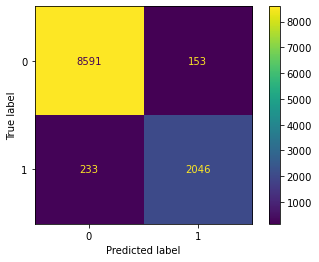

In [58]:
plot_confusion_matrix(final_model_pipeline, X_test['text_cleaned'], y_test)

In [59]:
X_test[y_pred != y_test]

,text_cleaned,text_tokenized_string,title,label,text_pos_lemmatized,text_snowball_stemmed,text_porter_stemmed,text_lancaster_stemmed
30018,a nail salon in tennessee is facing an uproar ...,nail salon tennessee facing uproar woman claim...,Woman Claims Nail Salon Posted Sign Saying Fat...,0,nail salon tennessee face uproar woman claim p...,nail salon tennesse face uproar woman claim po...,nail salon tennesse face uproar woman claim po...,nail salon ten fac upro wom claim post sign sa...
38259,ted cruz takes the cnbc debate hosts to task o...,ted cruz takes cnbc debate hosts task idiotic ...,Wow! Ted Cruz Blasts CNBC Anchor Over Ridiculo...,1,ted cruz take cnbc debate host task idiotic qu...,ted cruz take cnbc debat host task idiot quest...,ted cruz take cnbc debat host task idiot quest...,ted cruz tak cnbc deb host task idiot quest po...
25952,note this documentary short film was nominated...,note documentary short film nominated academy ...,4.1 Miles - The New York Times,0,note documentary short film nominate academy a...,note documentari short film nomin academi awar...,note documentari short film nomin academi awar...,not docu short film nomin academy award return...
36613,email the various communities in the state of ...,email various communities state kashmiri musli...,The Political and Cultural Richness of Kashmir...,1,email various community state kashmiri muslim ...,email various communiti state kashmiri muslim ...,email variou commun state kashmiri muslim kash...,email vary commun stat kashmir muslim kashmir ...
22675,the tagline for the gop race might as well be ...,tagline gop race might well make america misog...,"In Trump's World, Women Have Always Been Objects",0,tagline gop race might well make america misog...,taglin gop race might well make america misogy...,taglin gop race might well make america misogy...,taglin gop rac might wel mak americ misogyn ni...
...,...,...,...,...,...,...,...,...
25963,a california college professor who called pres...,california college professor called president ...,California College Professor Who Called Trump’...,0,california college professor call president tr...,california colleg professor call presid trump ...,california colleg professor call presid trump ...,californ colleg profess cal presid trump elect...
41253,donald trump s new adviser on tech matters wan...,donald trump new adviser tech matters wants ba...,The Trump Administration Is ALREADY Taking Ai...,1,donald trump new adviser tech matter want basi...,donald trump new advis tech matter want basic ...,donald trump new advis tech matter want basic ...,donald trump new adv tech mat want bas get rid...
39562,videos jill stein blasts ‘ attackdog ’ media c...,videos jill stein blasts attackdog media clint...,"Jill Stein Blasts ‘Attack-Dog’ Media, Clinton ...",1,video jill stein blast attackdog medium clinto...,video jill stein blast attackdog media clinton...,video jill stein blast attackdog media clinton...,video jil stein blast attackdog med clinton pr...
43579,donald trump values loyalty in a big way so wh...,donald trump values loyalty big way better inc...,TWELVE ON TRUMP TRANSITION TEAM Announced Toda...,1,donald trump value loyalty big way well incred...,donald trump valu loyalti big way better incre...,donald trump valu loyalti big way better incre...,donald trump valu loyal big way bet incred chi...


In [60]:
final_model_pipeline['Passive Aggressive Classifier'].__dict__

{'loss': 'hinge',
 'penalty': None,
 'learning_rate': 'optimal',
 'epsilon': 0.1,
 'alpha': 0.0001,
 'C': 0.1,
 'l1_ratio': 0.15,
 'fit_intercept': True,
 'shuffle': True,
 'random_state': None,
 'verbose': 0,
 'eta0': 1.0,
 'power_t': 0.5,
 'early_stopping': False,
 'validation_fraction': 0.1,
 'n_iter_no_change': 5,
 'warm_start': False,
 'average': False,
 'max_iter': 100,
 'tol': 0.001,
 'class_weight': None,
 'n_jobs': None,
 'n_features_in_': 3618753,
 'coef_': array([[ 0.11674478,  0.02342715, -0.00023039, ...,  0.03394073,
          0.        ,  0.        ]]),
 'intercept_': array([0.37302125]),
 't_': 628913.0,
 'classes_': array(['0', '1'], dtype='<U1'),
 '_expanded_class_weight': array([1., 1.]),
 'loss_function_': <sklearn.linear_model._sgd_fast.Hinge at 0x202fe0d2cb0>,
 'n_iter_': 23}

In [61]:
final_model_pipeline['Passive Aggressive Classifier'].coef_.shape

(1, 3618753)

In [62]:
len(final_model_pipeline['Vectorizer'].get_feature_names())

3618753

In [63]:
type(final_model_pipeline['Passive Aggressive Classifier'].coef_)

numpy.ndarray

In [64]:
type(final_model_pipeline['Vectorizer'].get_feature_names())

list

In [65]:
coefficients_list = final_model_pipeline['Passive Aggressive Classifier'].coef_.tolist()[0]
feature_names_list = final_model_pipeline['Vectorizer'].get_feature_names()

In [66]:
interpretation = tuple(zip(coefficients_list,feature_names_list))
sorted(interpretation, key = lambda x: (-x[0],x[1]))

[(11.684141952765723, 'via'),
 (7.0867987654932545, 'image'),
 (6.5231136082981305, 'image via'),
 (6.278214795330167, 'october'),
 (5.541409449147817, 'hillary'),
 (3.7595094300713687, 'november'),
 (3.5665827959184826, 'wire'),
 (3.0966903113410975, 'images'),
 (3.0121904467878897, 'on october'),
 (2.74814605739676, 'being'),
 (2.747594524497022, 'america'),
 (2.703424563021207, 'read more'),
 (2.679183045843047, 'the us'),
 (2.6105609044498723, 'century wire'),
 (2.509871007978682, 'obama'),
 (2.484362852483536, 'snip'),
 (2.4336410194044302, 'this'),
 (2.3392923251054887, 'fbi'),
 (2.280850541075159, 'featured image'),
 (2.2664863793750323, 'watch'),
 (2.2470325418303494, 'just'),
 (2.2393917220287176, 'entire story'),
 (2.2390124413753667, 'please'),
 (2.223673310886291, 'photo'),
 (2.1587874001668803, 'st century'),
 (2.080621268492604, 'yearold'),
 (2.022447159617163, 'video'),
 (2.0202872348579954, 'saidthe'),
 (2.010198556894329, 'below'),
 (2.000812445838962, 'share'),
 (2.00

In [67]:
sorted(interpretation)

[(-9.626813899955108, 'said'),
 (-5.889286126984722, 'follow'),
 (-5.792669429632952, 'on twitter'),
 (-5.703920252792579, 'twitter'),
 (-5.64428544850638, 'president donald'),
 (-4.870957414444071, 'said on'),
 (-4.433154794795051, 'on'),
 (-4.359616940377624, 'but'),
 (-3.754709543562365, 'on thursday'),
 (-3.751990155912274, 'on friday'),
 (-3.7141971539288794, 'on wednesday'),
 (-3.3835876612738947, 'com'),
 (-3.371142279862328, 'on tuesday'),
 (-3.2975081845083203, 'pic twitter'),
 (-3.2344003949287834, 'milo'),
 (-3.1756421222594433, 'mr'),
 (-3.0913480108962497, 'thursday'),
 (-3.0802830013399087, 'https'),
 (-3.056746152814966, 'tuesday'),
 (-3.03775560042322, 'on monday'),
 (-2.978595649463486, 'friday'),
 (-2.9457993822334765, 'pic'),
 (-2.789692854733191, 'follow him'),
 (-2.732461070957534, 'breitbart'),
 (-2.7242737630584086, 'ms'),
 (-2.6682702650744106, 'wednesday'),
 (-2.4666737021652616, 'in'),
 (-2.407929971524546, 'him on'),
 (-2.402877330443413, 'president'),
 (-2.3